In [ ]:
"""
This file is part of DPSE 

Copyright (C) 2025 ArtiMinds Robotics GmbH

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""

## Generate synthetic datasets for probe search

### Individual probes

In [1]:
from pathlib import Path
import os
import json
import shutil

from meta_learning_experiments.experiments.spike.generate_data_mlrc import generate_meta_train_data

NB_DIR = Path(os.path.abspath(os.path.dirname("__file__")))
OUTPUT_DIR = NB_DIR / "output"

SYNTHETIC_DATA_DIR = OUTPUT_DIR / "synthetic_data"
SYNTHETIC_CONTACT_TRAIN_DATA_DIR = SYNTHETIC_DATA_DIR / "contact_train"
SYNTHETIC_CONTACT_TEST_DATA_DIR = SYNTHETIC_DATA_DIR / "contact_test"
HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR = SYNTHETIC_DATA_DIR / "contact_hole_distributions_train"
HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR = SYNTHETIC_DATA_DIR / "contact_hole_distributions_test"

TRAINED_CONTACT_MODEL_OUTPUT_DIR = OUTPUT_DIR / "trained_contact_models"

OPTIMIZATION_RESULTS_DIR = OUTPUT_DIR / "optimization_results"

CLEAR_DATA = False
CLEAR_MODELS = False
CLEAR_OPTIMIZATIONS = True
DEBUG = True
GENERATE_DATA = False
TRAIN_MODELS = False
RUN_OPTIMIZATION = True

if CLEAR_DATA:
    if SYNTHETIC_DATA_DIR.exists():
        shutil.rmtree(SYNTHETIC_DATA_DIR.as_posix())

if not SYNTHETIC_CONTACT_TRAIN_DATA_DIR.exists():
    SYNTHETIC_CONTACT_TRAIN_DATA_DIR.mkdir(parents=True)
if not SYNTHETIC_CONTACT_TEST_DATA_DIR.exists():
    SYNTHETIC_CONTACT_TEST_DATA_DIR.mkdir(parents=True)
if not HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR.exists():
    HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR.mkdir(parents=True)
if not HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR.exists():
    HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR.mkdir(parents=True)

NUM_CONTACT_TRAIN_TASKS = 1000
NUM_CONTACT_TEST_TASKS = 10
NUM_EXAMPLES_PER_CONTACT_TASK = 128

with open(NB_DIR / "config" / "experiment_config_real.json") as experiment_config_file:
    experiment_config = json.load(experiment_config_file)

if GENERATE_DATA:
    generate_meta_train_data(NUM_CONTACT_TRAIN_TASKS, NUM_EXAMPLES_PER_CONTACT_TASK, SYNTHETIC_CONTACT_TRAIN_DATA_DIR, HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR, experiment_config, debug=False)

    generate_meta_train_data(NUM_CONTACT_TEST_TASKS, NUM_EXAMPLES_PER_CONTACT_TASK, SYNTHETIC_CONTACT_TEST_DATA_DIR, HOLE_DISTRIBUTIONS_TEST_OUTPUT_DIR, experiment_config, debug=False)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np


# Function to plot an ellipse representing a Gaussian
def plot_gaussian(ax, mean, cov, weight, color):
    # Eigen decomposition of covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(vals)  # 2 standard deviations for 95% confidence
    
    # Scale the size of the ellipse by the weight
    scale = np.sqrt(weight)
    width *= scale
    height *= scale

    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, alpha=0.5, color=color)
    ax.add_patch(ellipse)
    return mean, width, height

def plot_xy(ax, hole_distribution_data: dict, hole_centers: np.ndarray, sim: np.ndarray, real: np.ndarray):
    # Define colors for the components
    colors = plt.cm.viridis(np.linspace(0, 1, len(hole_distribution_data["means"])))

    # Plot each Gaussian component
    for mean, cov, weight, color in zip(hole_distribution_data["means"], hole_distribution_data["covs"], hole_distribution_data["weights"], colors):
        m, w, h = plot_gaussian(ax, mean, cov, weight, color)
        ax.scatter(*mean, color=color, s=50, label=f"Weight: {weight:.2f}")

    # Plot the hole centers
    ax.scatter(hole_centers[:, 0], hole_centers[:, 1], color="black", marker="x")

    # Plot the motions
    for sim_motion in sim:
        ax.scatter(sim_motion[:, 2], sim_motion[:, 3], color="green" if sim_motion[-1,1] > 0.5 else "red", alpha=0.5)
    for real_motion in real:
        ax.scatter(real_motion[:, 2], real_motion[:, 3], color="green" if real_motion[-1,1] > 0.5 else "red")

    ax.set_title("Simulated contact motions, top-down view [XY axis]")
    ax.set_xlabel("Position (X)")
    ax.set_ylabel("Position (Y)")
    ax.legend()
    ax.grid(True)

def plot_z(ax, sim: np.ndarray, real: np.ndarray):
    for sim_motion in sim:
        ax.plot(range(sim_motion.shape[0]), sim_motion[:, 4], color="green" if sim_motion[-1,1] > 0.5 else "red", alpha=0.5,
                linestyle="dashed")
    for real_motion in real:
        ax.plot(range(real_motion.shape[0]), real_motion[:, 4], color="green" if real_motion[-1,1] > 0.5 else "red")

    ax.set_title("Simulated contact motions [Z axis]")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Position (Z)")
    ax.legend()
    ax.grid(True)

def plot_fz(ax, sim: np.ndarray, real: np.ndarray):
    for sim_motion in sim:
        ax.plot(range(sim_motion.shape[0]), sim_motion[:, 2+7+2], color="green" if sim_motion[-1,1] > 0.5 else "red", alpha=0.5,
                linestyle="dashed")
    for real_motion in real:
        ax.plot(range(real_motion.shape[0]), real_motion[:, 2+7+2], color="green" if real_motion[-1,1] > 0.5 else "red")

    ax.set_title("Simulated contact motions [force along Z axis]")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Force (Z)")
    ax.legend()
    ax.grid(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

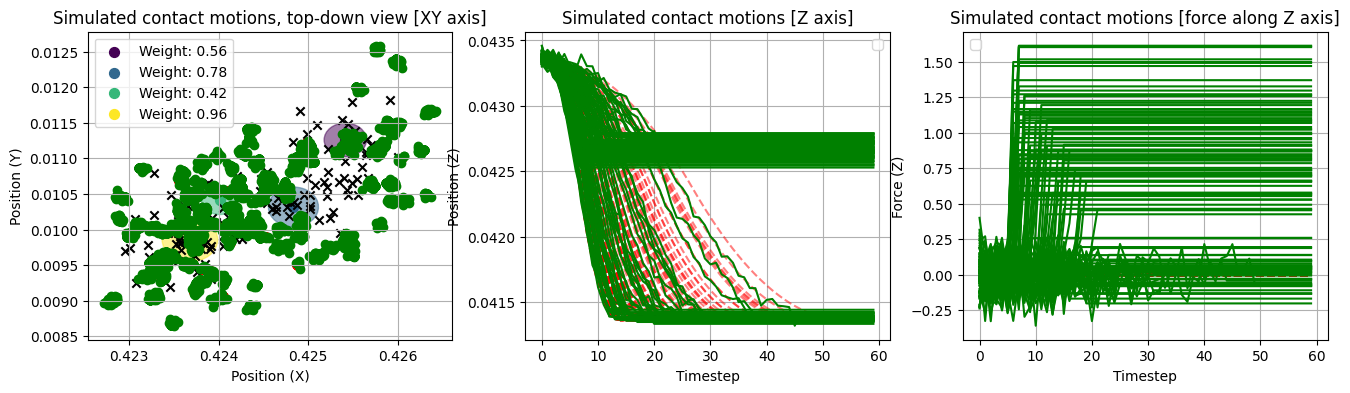

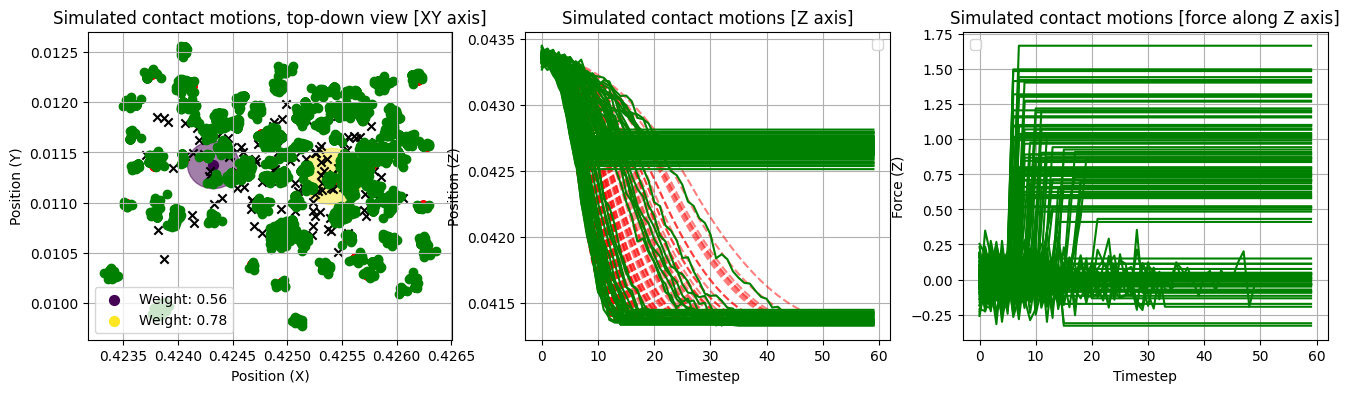

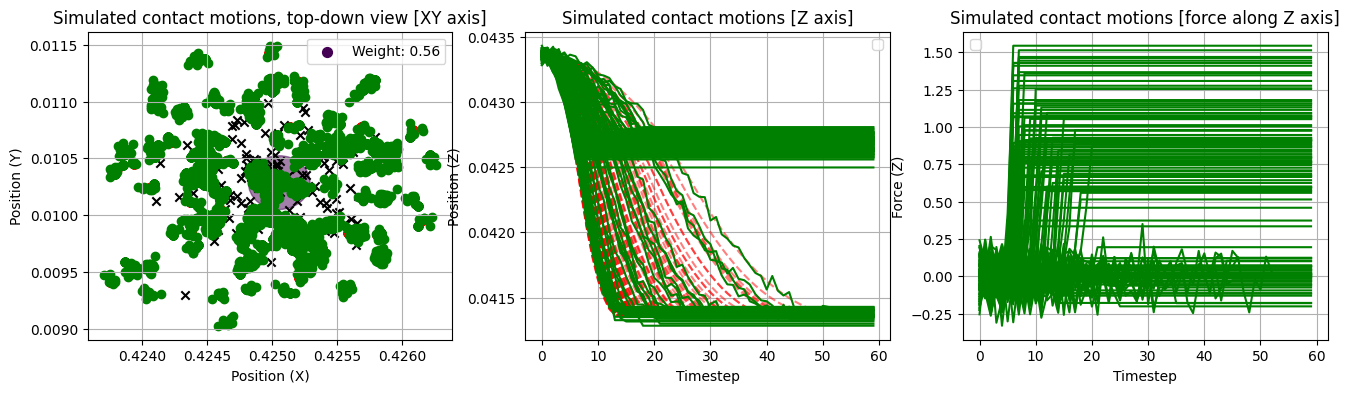

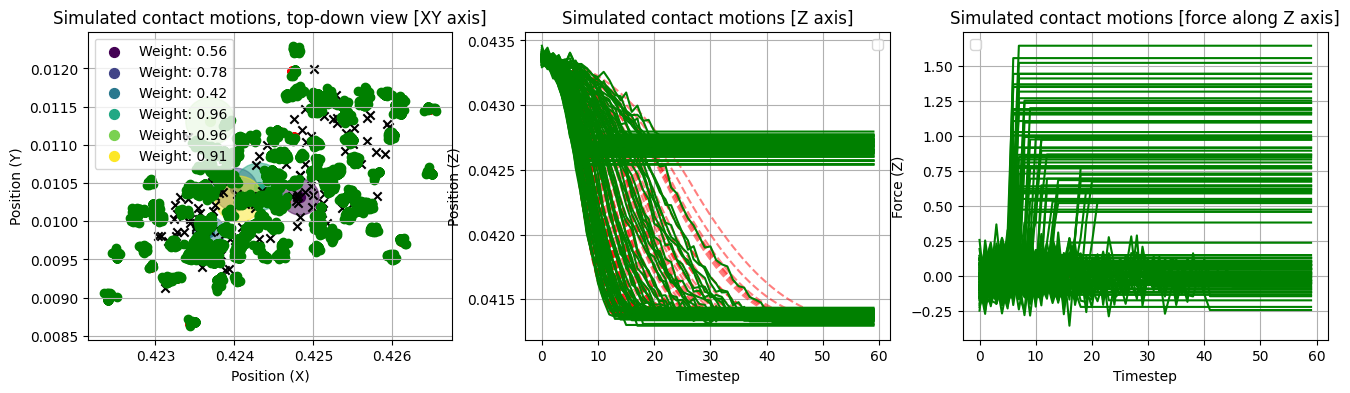

In [3]:
import itertools
import h5py

N_DATA_TO_PLOT = 4

# Plot some contact motion training data
for hole_distribution_dir, probe_filepath in zip(
    itertools.islice(HOLE_DISTRIBUTIONS_TRAIN_OUTPUT_DIR.glob("*"), N_DATA_TO_PLOT),
    itertools.islice(SYNTHETIC_CONTACT_TRAIN_DATA_DIR.glob("*"), N_DATA_TO_PLOT)):

    with open(hole_distribution_dir / "hole_distribution.json") as hole_distribution_json:
        hole_distribution_data = json.load(hole_distribution_json)
    
    with h5py.File(probe_filepath, "r") as f:
        hole_centers_group = f.get("hole_centers")
        hole_centers = np.concatenate([hole_centers_group[key][:] for key in hole_centers_group.keys()])

        sim_group = f.get("sim")
        sim = np.concatenate([sim_group[key][:] for key in sim_group.keys()])

        real_group = f.get("real")
        real = np.concatenate([real_group[key][:] for key in real_group.keys()])

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
        plot_xy(axes[0], hole_distribution_data, hole_centers, sim, real)
        plot_z(axes[1], sim, real)
        plot_fz(axes[2], sim, real)
    

In [4]:
from meta_learning_experiments.experiments.spike.spike_search import SpikeSearch
from spi.neural_templates.program_primitive import ProgramPrimitive
from graphmodel.graphmodel.graph_node_move_linear_relative_contact import GraphNodeMoveLinearRelativeContact
from spi.simulation.static_simulator import StaticSimulator
from spi.neural_templates.models.seq2seq.model import ResidualGRU
import torch

NUM_PROBES_PER_SEARCH = 16

contact_limits_x = torch.tensor(experiment_config["mlrc"]["limits_x"], dtype=torch.float32)
contact_limits_s = torch.tensor(experiment_config["mlrc"]["limits_s"], dtype=torch.float32)
contact_limits_Y = torch.tensor(experiment_config["mlrc"]["limits_Y"], dtype=torch.float32) 

with open(NB_DIR / "config" / "model_config_mlrc.json") as contact_model_config_file:
    contact_model_config = json.load(contact_model_config_file)

contact_simulator = StaticSimulator(GraphNodeMoveLinearRelativeContact(), experiment_config["sampling_interval"], multiproc=False)

contact_model = ResidualGRU(static_input_size=7+2+2, sequence_input_size=2+7+6, environment_embedding_size=None, hidden_size=contact_model_config["hidden_size"], output_size=2+7+6, num_layers=contact_model_config["num_layers"], dropout_p=contact_model_config["dropout_p"])
contact_skill = ProgramPrimitive("Move Linear Relative Contact", 11, contact_limits_x,
                                                                     contact_limits_s, contact_limits_Y, contact_simulator,
                                                                     contact_model_config,
                                                                     contact_model)
probe_skill = SpikeSearch(NUM_PROBES_PER_SEARCH, contact_skill, experiment_config)

ResidualGRU, total number of parameters: 567739


In [5]:
# Train MLRC

from spi.neural_programs.train_program_component_sgd import train_sgd

if CLEAR_MODELS:
    if TRAINED_CONTACT_MODEL_OUTPUT_DIR.exists():
        shutil.rmtree(TRAINED_CONTACT_MODEL_OUTPUT_DIR.as_posix())
        
if not TRAINED_CONTACT_MODEL_OUTPUT_DIR.exists():
    TRAINED_CONTACT_MODEL_OUTPUT_DIR.mkdir(parents=True)

if TRAIN_MODELS:
    train_sgd(contact_skill, SYNTHETIC_CONTACT_TRAIN_DATA_DIR, TRAINED_CONTACT_MODEL_OUTPUT_DIR, invert_success_label=True)

In [6]:
from meta_learning_experiments.experiments.spike.test_mlrc import finetune_and_test

# Test trained contact model
model_dir = list(sorted(TRAINED_CONTACT_MODEL_OUTPUT_DIR.glob("*")))[-1]    # Assume newest model is last when sorted

if TRAIN_MODELS:
    finetune_and_test(model_dir, SYNTHETIC_CONTACT_TEST_DATA_DIR, experiment_config,
                    samples_per_task=NUM_EXAMPLES_PER_CONTACT_TASK, adapt_steps=128,
                    learning_rate=5e-4, show=False, mc_dropout=False)

In [ ]:
from types import SimpleNamespace
from meta_learning_experiments.experiments.common_utils import MetaDataset
from meta_learning_experiments.experiments.spike.optimize_spikes import optimize_for_task
from meta_learning_experiments.experiments.spike.spike_search_tools import augment_dataset, spike_search_grid_xy_from_input_tensor

if CLEAR_OPTIMIZATIONS:
    if OPTIMIZATION_RESULTS_DIR.exists():
        shutil.rmtree(OPTIMIZATION_RESULTS_DIR.as_posix())

if not OPTIMIZATION_RESULTS_DIR.exists():
    OPTIMIZATION_RESULTS_DIR.mkdir(parents=True)

meta_test_tasks = list(SYNTHETIC_CONTACT_TEST_DATA_DIR.glob("*"))
meta_test_set = MetaDataset(meta_test_tasks)
meta_test_set = augment_dataset(MetaDataset(meta_test_tasks), experiment_config, 256)

SPI_ITERATIONS = 250        # Number of iterations of parameter optimization
# SPI_ITERATIONS = 3
SPI_LR = 5e-5
ADAPT_STEPS = 512           # Finetuning steps on the task at hand
NUM_TESTS = 10              # Number of trials (optimizations) per task. Each task has several different examples in its test data

args = SimpleNamespace(trained_mlrc_dir=model_dir, model_type="finetune", results_dir=OPTIMIZATION_RESULTS_DIR, show=True)
results_for_all_tasks = []
for task_idx, task in enumerate(meta_test_set):
    task_results = optimize_for_task(args, experiment_config, SPI_ITERATIONS, SPI_LR, task, task_idx,
                                     adapt_steps=ADAPT_STEPS, num_tests=NUM_TESTS)
    results_for_all_tasks.append(task_results)
    if task_idx > 1:    # TODO: More tasks!
        break
torch.save(OPTIMIZATION_RESULTS_DIR / "results.pt", results_for_all_tasks)

/home/alt/DATA/dpse_minimal/spi/common/trajectory.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  success = torch.tensor(self.success_label, dtype=torch.float32).view(1, 1).repeat(base_tensor.size(0), 1)


/tmp/tmpzk35_gpc/0.h5 does not exist, creating...


/home/alt/DATA/dpse_minimal/.venv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


/tmp/tmpzk35_gpc/1.h5 does not exist, creating...
/tmp/tmpzk35_gpc/2.h5 does not exist, creating...
/tmp/tmpzk35_gpc/3.h5 does not exist, creating...
/tmp/tmpzk35_gpc/4.h5 does not exist, creating...
/tmp/tmpzk35_gpc/5.h5 does not exist, creating...
/tmp/tmpzk35_gpc/6.h5 does not exist, creating...
/tmp/tmpzk35_gpc/7.h5 does not exist, creating...
/tmp/tmpzk35_gpc/8.h5 does not exist, creating...
/tmp/tmpzk35_gpc/9.h5 does not exist, creating...
ResidualGRU, total number of parameters: 567739
Proportion of successful executions in fine-tuning train set: 1.0000


/home/alt/DATA/dpse_minimal/spi/neural_templates/models/seq2seq/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load(filepath, map_location=device)

Results saved under /tmp/tmplgkx1o0b/ProgramPrimitive_(20250316-112805)
ResidualGRU, total number of parameters: 567739
optimize_inputs_spi::optimize: Starting optimization...
[  0] Loss:  1.0365, Time: 1.88
[  1] Loss:  1.0395, Time: 0.71
[  2] Loss:  1.0382, Time: 0.71
[  3] Loss:  1.0371, Time: 0.72
[  4] Loss:  1.0365, Time: 0.74
[  5] Loss:  1.0364, Time: 0.76
[  6] Loss:  1.0365, Time: 0.93
[  7] Loss:  1.0365, Time: 0.78
[  8] Loss:  1.0365, Time: 0.78
[  9] Loss:  1.0365, Time: 0.78
[ 10] Loss:  1.0364, Time: 0.79
[ 11] Loss:  1.0360, Time: 0.78
[ 12] Loss:  1.0347, Time: 0.79
[ 13] Loss:  1.0347, Time: 0.78
[ 14] Loss:  1.0347, Time: 0.79
[ 15] Loss:  1.0347, Time: 0.80
[ 16] Loss:  1.0346, Time: 0.79
[ 17] Loss:  1.0342, Time: 0.79
[ 18] Loss:  1.0340, Time: 0.78
[ 19] Loss:  1.0333, Time: 0.90
[ 20] Loss:  1.0333, Time: 0.78
[ 21] Loss:  1.0327, Time: 0.74
[ 22] Loss:  1.0328, Time: 0.75
[ 23] Loss:  1.0323, Time: 0.76
[ 24] Loss:  1.0318, Time: 0.76
[ 25] Loss:  1.0314, Tim

100%|██████████| 512/512 [00:04<00:00, 118.67it/s]


Results saved under /tmp/tmppc0b96x9/ProgramPrimitive_(20250316-120139)
ResidualGRU, total number of parameters: 567739
optimize_inputs_spi::optimize: Starting optimization...
[  0] Loss:  1.0359, Time: 0.71
[  1] Loss:  1.0389, Time: 0.77
[  2] Loss:  1.0406, Time: 0.81
[  3] Loss:  1.0382, Time: 0.81
[  4] Loss:  1.0360, Time: 0.82
[  5] Loss:  1.0357, Time: 0.79
[  6] Loss:  1.0357, Time: 0.78
[  7] Loss:  1.0357, Time: 0.90
[  8] Loss:  1.0363, Time: 0.78
[  9] Loss:  1.0357, Time: 0.79
[ 10] Loss:  1.0356, Time: 0.80
[ 11] Loss:  1.0342, Time: 0.78
[ 12] Loss:  1.0335, Time: 0.79
[ 13] Loss:  1.0328, Time: 0.80
[ 14] Loss:  1.0325, Time: 0.80
[ 15] Loss:  1.0323, Time: 0.79
[ 16] Loss:  1.0321, Time: 0.80
[ 17] Loss:  1.0316, Time: 0.79
[ 18] Loss:  1.0312, Time: 0.80
[ 19] Loss:  1.0311, Time: 0.80
[ 20] Loss:  1.0310, Time: 0.91
[ 21] Loss:  1.0310, Time: 0.80
[ 22] Loss:  1.0312, Time: 0.81
[ 23] Loss:  1.0312, Time: 0.81
[ 24] Loss:  1.0305, Time: 0.80
[ 25] Loss:  1.0303, Tim

100%|██████████| 512/512 [00:04<00:00, 112.63it/s]


Results saved under /tmp/tmpvvp6tar1/ProgramPrimitive_(20250316-123511)
ResidualGRU, total number of parameters: 567739
optimize_inputs_spi::optimize: Starting optimization...
[  0] Loss:  1.0318, Time: 0.65
[  1] Loss:  1.0348, Time: 0.68
[  2] Loss:  1.0333, Time: 0.70
[  3] Loss:  1.0322, Time: 0.69
[  4] Loss:  1.0315, Time: 0.69
[  5] Loss:  1.0314, Time: 0.68
[  6] Loss:  1.0332, Time: 0.69
[  7] Loss:  1.0322, Time: 0.69
[  8] Loss:  1.0312, Time: 0.85
[  9] Loss:  1.0309, Time: 0.73
[ 10] Loss:  1.0296, Time: 0.72
[ 11] Loss:  1.0289, Time: 0.71
[ 12] Loss:  1.0288, Time: 0.71
[ 13] Loss:  1.0292, Time: 0.73
[ 14] Loss:  1.0286, Time: 0.75
[ 15] Loss:  1.0285, Time: 0.78
[ 16] Loss:  1.0284, Time: 0.73
[ 17] Loss:  1.0275, Time: 0.79
[ 18] Loss:  1.0273, Time: 0.77
[ 19] Loss:  1.0271, Time: 0.83
[ 20] Loss:  1.0267, Time: 0.82
[ 21] Loss:  1.0260, Time: 0.83
[ 22] Loss:  1.0257, Time: 0.95
[ 23] Loss:  1.0259, Time: 0.82
[ 24] Loss:  1.0257, Time: 0.79
[ 25] Loss:  1.0261, Tim

In [9]:
print(results_for_all_tasks)

KeyboardInterrupt: 

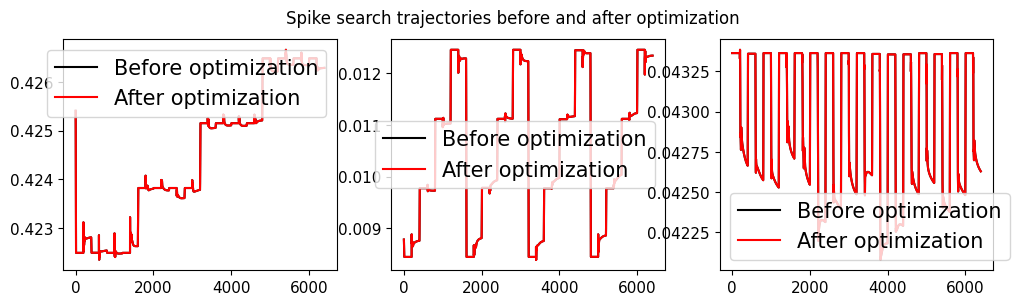

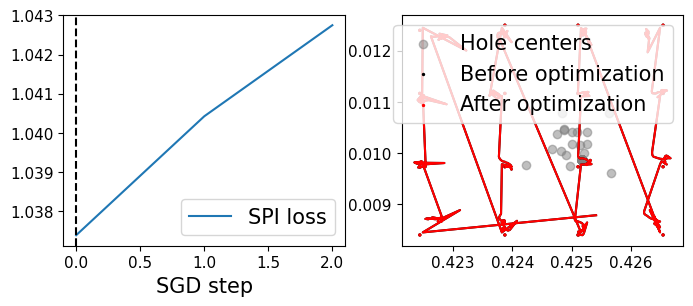

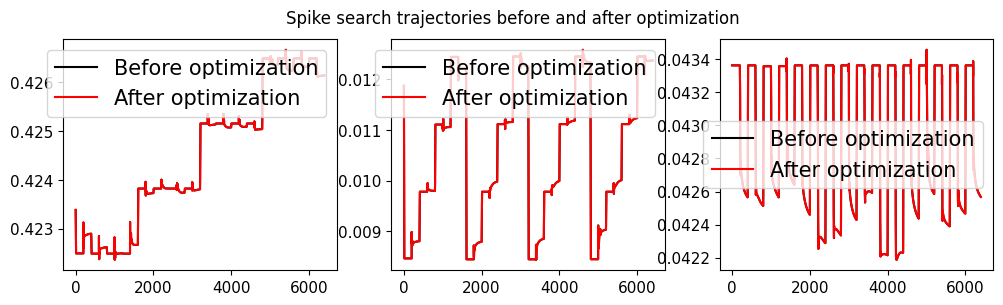

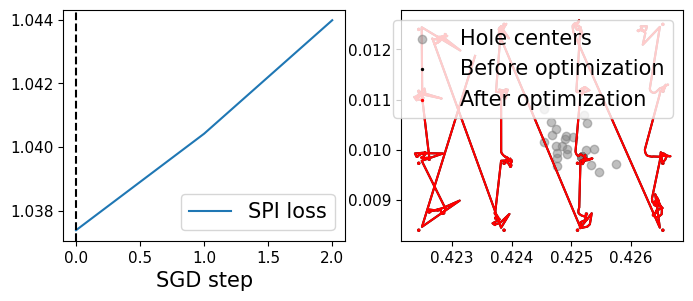

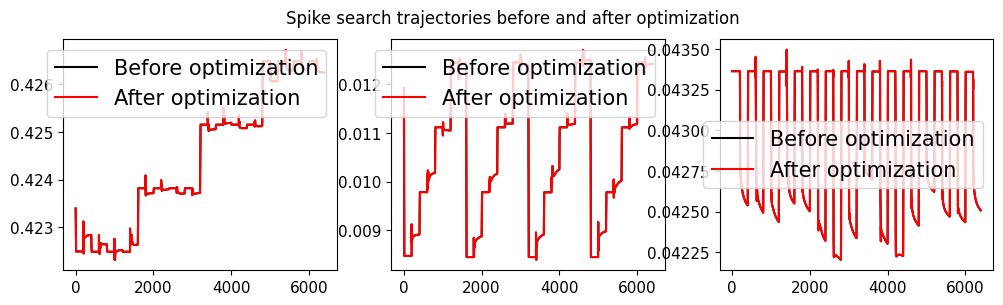

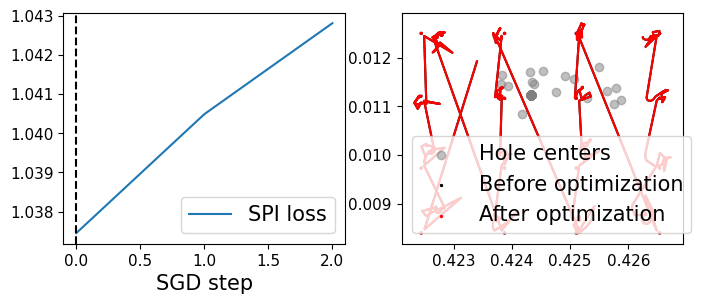

In [ ]:
for task_results in results_for_all_tasks:
    for trial in task_results:
        losses = trial["loss"]
        Ys = trial["Y"]
        xs = trial["x"]
        test_hole_centers = trial["hole_centers"]

        min_loss_idx = np.argmin(losses)
        initial_x = xs[0][0]
        initial_grid_xy = spike_search_grid_xy_from_input_tensor(initial_x.unsqueeze(0))
        initial_Y = Ys[0][0]
        best_Y = Ys[min_loss_idx][0]
        best_x = xs[min_loss_idx][0]
        final_grid_xy = spike_search_grid_xy_from_input_tensor(best_x.unsqueeze(0))

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
        fig.suptitle("Spike search trajectories before and after optimization")
        for dim in range(3):
            ax[dim].plot(range(len(initial_Y)), initial_Y[:, 2+dim], color="black", label="Before optimization")
            ax[dim].plot(range(len(best_Y)), best_Y[:, 2+dim], color="red", label="After optimization")
            ax[dim].legend()
        plt.show()

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        ax[0].plot(range(len(losses)), losses, label="SPI loss")
        ax[0].axvline(x=min_loss_idx, color="black", linestyle="--")
        ax[0].set_xlabel("SGD step")
        ax[0].legend()

        ax[1].scatter(test_hole_centers[:, 0].cpu(), test_hole_centers[:, 1].cpu(), color="gray", alpha=0.5,
                        label="Hole centers")
        ax[1].plot(initial_Y[:, 2], initial_Y[:, 3], color="black")
        ax[1].scatter(initial_grid_xy[0,:,0], initial_grid_xy[0,:,1], color="black", s=[2 for _ in range(final_grid_xy.shape[1])],
                        label="Before optimization")
        ax[1].plot(best_Y[:, 2], best_Y[:, 3], color="red")
        ax[1].scatter(final_grid_xy[0,:,0], final_grid_xy[0,:,1], color="red", s=[2 for _ in range(final_grid_xy.shape[1])],
                        label="After optimization")
        ax[1].legend()

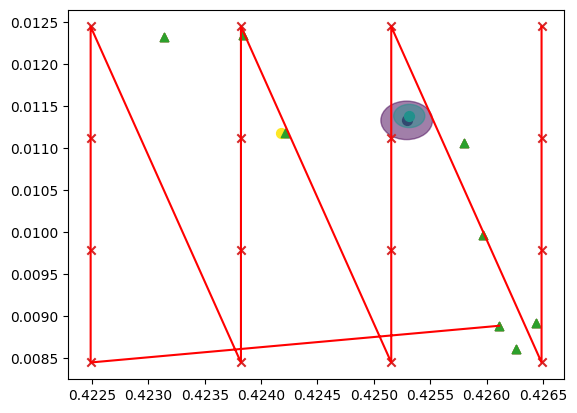

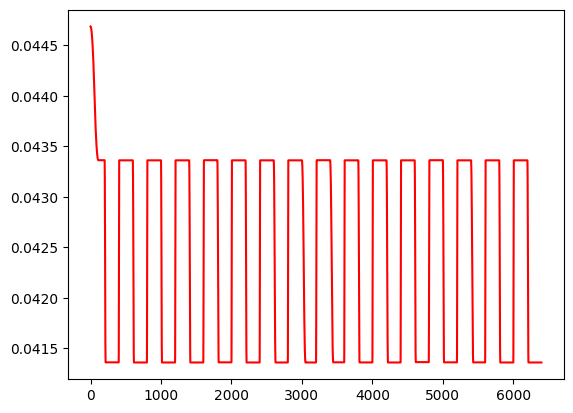

In [ ]:
### Combined probe search

from meta_learning_experiments.experiments.spike.spike_search_tools import random_spike_search_relative_inputs, random_spike_search_start_point
from spi.common.trajectory import Trajectory
from spi.physics.apply_physics_spike_search import apply_physics

NUM_PROBE_TASKS = 4
NUM_EXAMPLES_PER_PROBE_TASK = 8

for probe_task in range(NUM_PROBE_TASKS):
    hole_distribution = 
    # CAUTION: Currently all probe searches per task have the same parameterizations (grid, fixed vel & acc)
    probe_search_inputs = torch.stack([probe_skill.make_inputs(experiment_config, NUM_PROBES_PER_SEARCH, random=False) for _ in range(NUM_EXAMPLES_PER_PROBE_TASK)])
    probe_search_start_points = random_spike_search_start_point(NUM_EXAMPLES_PER_PROBE_TASK, experiment_config)
    
    hole_distribution_colors = plt.cm.viridis(np.linspace(0, 1, len(hole_distribution_data["means"])))

    probe_search_trajs, end_states = probe_skill(probe_search_inputs, probe_search_start_points)
    
    if probe_task == 0:
        fig, ax = plt.subplots()

        for mean, cov, weight, color in zip(hole_distribution_data["means"], hole_distribution_data["covs"], hole_distribution_data["weights"], hole_distribution_colors):
            m, w, h = plot_gaussian(ax, mean, cov, weight, color)
            ax.scatter(*mean, color=color, s=50, label=f"Weight: {weight:.2f}")
            ax.scatter(probe_search_start_points[:, 0].numpy(), probe_search_start_points[:, 1].numpy(), marker="^")
        
        split_inputs = SpikeSearch.split_inputs(NUM_PROBES_PER_SEARCH, probe_search_inputs)
        probe_points = torch.stack(split_inputs[::2]).transpose(1,0)[..., :3]

        for i, traj in enumerate(probe_search_trajs[:1]):
            ax.plot(traj[:, 2].numpy(), traj[:, 3].numpy(), color="green" if traj[-1,1] > 0.5 else "red")
            ax.scatter(probe_points[i, :, 0], probe_points[i, :, 1], marker="x")
        plt.show()

        fig, ax = plt.subplots()
        for i, traj in enumerate(probe_search_trajs[:1]):
            ax.plot(range(len(traj)), traj[:, 4].numpy(), color="green" if traj[-1,1] > 0.5 else "red")
        plt.show()

    
    # # Apply physics
    # for probe_search_traj in probe_search_trajs:
    #     t = Trajectory.from_tensor(probe_search_traj)
    #     apply_physics(physics_config, t, hole_centers)

    



## Train models

### Individual probes

### Combined probe search

## Test models

## Optimize probe search parameters

## Visualize optimization